# Thesis Project

probably some text here describing the project


## Requirements and Imports

All requirements in this project are managed by `Pipenv` and are specified in the `Pipfile`, which can be found in the same directory as this notebook.

In [1]:
# Basic imports
import os
import re
import glob
import wfdb
import time
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wfdb import processing
from functools import partial

# PyTorch related imports
import torch
import torchinfo
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# RayTune related imports
from ray import tune, put, get, ray
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# Scipy and Sklearn related imports
from scipy import signal, stats
from statsmodels.tsa.stattools import ccf
from skimage.restoration import denoise_wavelet
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Configuration

The following code cell can be used to configure certain general aspects of the project related to random number generation, graphics card utilization, model and data loading, noise modeling and training.
To specify offsets (for instance for the sampling rate or the segment size), please refer to the official [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [2]:
# Set a random seed for pytorch (always split the data the same way), for the random package and for numpy. Required for reproducibility.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# If a GPU (Cuda) is available, it will be used to train and test the machine learning models.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# The directory for saving and loading the trained models.
model_directory = './models/'

# Here, some basic settings for the datasets and are set.
data_directory = './data/'
sampling_rate = 100 # Hz
window_size = 512
step_size = 64

train_split = 0.8
val_split = 0.2

# The target noise SNR values for training and testing.
train_target_snr_dbs = [-2.5, 0, 2.5, 7.5, 10, 12.5] # dB

test_target_snr_dbs =  [-1, 0, 2, 5, 7] # dB
# test_target_snr_dbs = [-1]
# test_target_snr_dbs = [7]

# Number of epochs for training.
num_epochs = 64

## Dataset

This is a utility class which is used to manage the required data and for adding and generating noise to the data samples. It inherits from the PyTorch `Dataset` class, which provides tools like splitting the data into train, validation and test subsets or using it in dataloaders to efficiently access the data in batches while training and testing. The dataset for this experiment comprises the [CEBS](https://physionet.org/content/cebsdb/1.0.0/) dataset, the [IEEE](https://ieee-dataport.org/documents/mechanocardiograms-ecg-reference) dataset and another dataset, called [D2](https://zenodo.org/record/5279448). Either SCG or ECG samples can be used as x values and SCG and noisy SCG samples as y values. The data from the specified datasets will be loaded directly when initializing an object of the class. Each dataset will be imported, depending on its specific characteristics, the schemas will be normalized, the dataset will be resampled and each dataset will be splitted into windows with a size of `segment_size_samples` and an offset of `step_size`. Subsequently, all datasets will be combined. Initially no noise will be added to the data, so that training and testing can be done with different noise levels. The noise generated is gaussian white noise and/or from a second noise model which focusses on motion noise. The two noise models can be used independently or together, with a certain probability in generating WGN. The motion focussed noise model adopts noise data from a dataset that comprises [data from a chest-worn accelerometer](https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer) while doing 7 different activities. The gravity component will be removed from the data as it is already present in the SCG datasets. To model the noise, `segment_size_samples` long consecutive samples will be extracted and added to the y-samples. Please note that the code for generating the WGN noise was adopted from [this](https://stackoverflow.com/a/53688043) example.

In [3]:
'''
A method to normalize the input data between -1 and 1. Returns the minimum and maximum values of the original signal as well for later denormalization.
:param data: The data that should be normalized.
'''
def normalize(data):
    # If the data consists of several arrays, concatenate them to find the minimum and maximum.
    data_concat = np.concatenate(data) if data[0].ndim == 1 else data
    min_val = np.min(data_concat)
    max_val = np.max(data_concat)
    data_norm = 2 * (data - min_val) / (max_val - min_val) - 1
    return data_norm, min_val, max_val

'''
Denormalizes the input data to its original form, given the minimum and maximum values of the original signal.
:param data: The data that should be normalized.
:param min_val: The minimum value of the original, not normalized data.
:param max_val: The maximum value of the original, not normalized data.
'''
def denormalize(data, min_val, max_val):
    data_denorm = (max_val * data + max_val - data * min_val + min_val) / 2
    return data_denorm

'''
A butter bandpass filter for the input signal.
:param input_signal: The signal to which the filter should be applied to.
:param order: The order of the filter.
:param fs: The frequency space.
:param lowcut: The highcut of the filter.
:param highcut: The lowcut of the filter.
'''
def bandpass(input_signal, order=4, fs=100.0, lowcut=5.0, highcut=30.0):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a, = signal.butter(order, [low, high], 'bandpass', analog=False)
    y = signal.filtfilt(b, a, input_signal, axis=0)

    return y

'''
A method to filter out peaks of a given input signal by comparing the z-score of anss input sample to a threshold value. 
:param input_signal: The signal on which the filter should be applied to.
:param z_score_th: Every sample with a z-score above this threshold will be set to the mean of the signal.
'''
def filter_peaks(input_signal, z_score_th=7):
    output_signal = input_signal.copy()
    output_signal.loc[np.abs(stats.zscore(output_signal)) > z_score_th] = output_signal.mean()
    return output_signal

In [4]:
class SCGData(Dataset):

    '''
    A dataset class to manage all the different datasets being used in this project.

    :param directory: The directory where the datasets (each in their own directory) are located.
    :param datasets: A list of strings 'CEBS', 'D2' or 'IEEE' of the datasets that should be loaded.
    :param transform: The transformation that will be applied to the data samples when they are accessed.
    :param ecg: If true, the y_data samples will be ecg data and otherwise the noisy SCG samples.
    :param noise: If true, noise may be added to the x samples by calling the add_noise method. Otherwise, calling this method will have no effects.
    :param use_bandpass: If true, a bandpass filter will be applied to the noise samples after adding noise within the add_noise method.
    '''
    def __init__(self, directory, datasets, sampling_rate, window_size, step_size, transform=None, ecg=False, noise=True, use_bandpass=False):

        self.directory = directory
        self.datasets = datasets
        self.sampling_rate = sampling_rate
        self.window_size = window_size
        self.step_size = step_size
        self.transform = transform
        self.ecg = ecg

        self.noise = noise
        self.data_motion_noise = None # Saves the data loaded from the motion dataset to add motion noise later.
        self.use_bandpass = use_bandpass
        
        # The min/max values after normalizing the noise noisy x_data. Used for later denormalization to calculate the SNR.
        self.min_val = None
        self.max_val = None

        # Load the motion noise data.
        self.__load_motion_noise_data()

        # Load and preprocess the requested datasets from `datasets`.
        data = self.__load_datasets()
        
        # Clean SCG data to add noise in order to generate x_data.
        self.scg_clean = data.SCG.values
        
        # The y values are either ECG samples (when ecg=True) or SCG samples (when ecg=False). Noise will be added later.
        if self.ecg:
            self.x_data = data.SCG.values
            self.y_data = data.ECG.values
        else:
            self.x_data = data.SCG.values
            self.y_data = data.SCG.values

        self.n_samples = data.shape[0]

    '''
    The function may be called to add noise to the x values when self.noise is True.

    :param target_snr_dbs: A list of SNR values to be added with the WGN model. 
    :param noise_model: This parameter can either be 'WGN' for the White Gaussian Noise Model, 'MOTION' for the motion noise model or 'BOTH' for both noise models to be added to the dataset.
    :param wgn_prob: Determines the probability with what the WGN model will be added to the dataset if 'BOTH' was chosen as the noise model.
    '''
    def add_noise(self, target_snr_dbs, noise_model='WGN', wgn_prob=0.33):

        if self.noise:
            if noise_model == 'WGN':
                data_noise = np.array([self.__add_gaussian(inputs, target_snr_dbs) for inputs in self.scg_clean])
            elif noise_model == 'MOTION':
                data_noise = np.array([self.__add_motion(inputs) for inputs in self.scg_clean])
            elif noise_model == 'BOTH':
                data_noise = np.array([self.__add_gaussian(inputs, target_snr_dbs) if random.random() < wgn_prob else self.__add_motion(inputs) for inputs in self.scg_clean])

            if self.use_bandpass:
                data_noise = np.array([bandpass(inputs) for inputs in data_noise])

            self.x_data, self.min_val, self.max_val = normalize(data_noise)

    '''
    A function to add motion noise to its inputs.

    :param data: The data, to which the noise should be added.
    '''
    def __add_motion(self, data):
        
        # Randomly select `len(data)` consecutive samples from the processed noise dataset.
        num_samples = len(data)
        rows = range(self.data_motion_noise.shape[0])
        index_start = random.randint(rows.start, rows.stop - num_samples)
        noise = self.data_motion_noise.iloc[index_start:index_start + num_samples]
        
        # Only add 50 % of noise to the data.
        return data + 0.5 * noise

    '''
    A function to add WGN noise to its inputs.

    :param data: The data, to which the noise should be added.
    :param target_snr_dbs: A list of SNR values to be added. 
    '''
    def __add_gaussian(self, data, target_snr_dbs):

        target_snr_db = random.choice(target_snr_dbs)

        data_avg_watts = np.mean(data ** 2)
        data_avg_db = 10 * np.log10(data_avg_watts)

        noise_avg_db = data_avg_db - target_snr_db
        noise_avg_watts = 10 ** (noise_avg_db / 10)

        mean_noise = 0
        noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data))
        
        return data + noise

    '''
    Loads the motion noise dataset, upsamples, filters and normalizes it.
    '''
    def __load_motion_noise_data(self):
        data = pd.DataFrame()

        for i in range(1, 16):
            rel_path = os.path.join('NOISE_ACC', f'{i}.csv')
            df = pd.read_csv(os.path.join(self.directory, rel_path), header=None, usecols=[3, 4], names=['Z', 'labels'])
            
            df_resample = pd.DataFrame()
            frequency = 52

            # Upsample the z-axis data, subtract the mean (gravity component), remove outliers and normalize it 
            df_resample['Z'] = processing.resample_sig(df['Z'], frequency, self.sampling_rate)[0]
            df_resample['Z'] = df_resample['Z'] - df_resample['Z'].mean() # Remove the gravity component from the acceleration data
            df_resample['Z'] = filter_peaks(df_resample['Z'], z_score_th=5)
            df_resample['Z'], _, _ = normalize(df_resample['Z'])

            # Upsample the labels, round them and prevent values larger than 7 and smaller than 1.
            df_resample['labels'] = processing.resample_sig(df['labels'], frequency, self.sampling_rate)[0]
            df_resample['labels'] = df_resample['labels'].round(decimals=0)
            df_resample.loc[df_resample['labels'] > 7, 'labels'] = 7
            df_resample.loc[df_resample['labels'] < 1, 'labels'] = 1

            data = pd.concat((data, df_resample))

        # The different activities in the dataset.
            # 1: Working at Computer
            # 2: Standing Up, Walking and Going up\down stairs
            # 3: Standing
            # 4: Walking
            # 5: Going Up\Down Stairs
            # 6: Walking and Talking with Someone
            # 7: Talking while Standing

        # Here it is possible to only allow certain activities in the noise dataset.
        # self.data_motion_noise = data.loc[data['labels'] == 4, 'Z']
        self.data_motion_noise = data['Z']

    
    '''
    Loads one file of the CEBS dataset and processes it. This includes resampling, filtering and splitting into groups of `self.window_size` samples.

    :param filename: The name of the specific file to be loaded.
    '''
    def __load_cebs(self, filename):
        
        # Using WFDB to import the files.
        record = wfdb.rdsamp(filename)
        data = record[0]
        metadata = record[1]

        frequency = metadata['fs']
        column_names = metadata['sig_name']

        data = pd.DataFrame(data, columns=column_names)
        data.drop(['II', 'RESP'], axis=1, inplace=True)
        data.rename(columns={'I': 'ECG'}, inplace=True)

        # Resample the data into the desired sampling rate and bandpass filter the scg samples.
        scg = processing.resample_sig(data['SCG'], frequency, self.sampling_rate)[0]
        scg = bandpass(scg, order=4, fs=100.0, lowcut=5.0, highcut=30.0)
        ecg = processing.resample_sig(data['ECG'], frequency, self.sampling_rate)[0]

        data = pd.DataFrame({'SCG': scg, 'ECG': ecg})

        # Filter out outliers from the scg data
        data['SCG'] = filter_peaks(data['SCG'], z_score_th=7)

        # Split the data into groups with `self.window_size` and an offset of `self.step_size` samples.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=self.window_size, step=self.step_size) if x.shape[0] == self.window_size])
        data.columns = ['ECG', 'SCG']

        # Normalize the ECG and SCG data
        data['ECG'], _, _ = normalize(data['ECG'])
        data['SCG'], _, _ = normalize(data['SCG'])
        
        return data


    '''
    Loads one file of the D2 dataset and processes it. This includes resampling, filtering and splitting into groups of `self.window_size` samples.

    :param filename: The name of the specific file to be loaded.
    '''
    def __load_d2(self, filename):

        # Since the files are not structured the same, they have to be imported differently. The following code does that.
        # Regex to identify files with specific names, as they are structured differently.
        regex_up_1 = re.compile(r'./data/D2/UP-(((0|1)[0-9])|(20|21))-*') # Files named UP-[01-21]-Raw.csv
        regex_up_2 = re.compile(r'./data/D2/UP-(22|23)-*') # Files named UP-[22-23]-Raw.csv

        # Import the file depending on its structure.
        if re.match(r'./data/D2/CP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['Shimmer_D0CD_ECG_LA-RA_24BIT_CAL', 'Shimmer_D0CD_Accel_LN_Z_CAL'], 
                    dtype={'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL': 'float', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL': 'ECG', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
            frequency = 256
        elif regex_up_1.match(filename):
            data = pd.read_csv(filename, 
                    sep='	', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
            frequency = 256
        elif regex_up_2.match(filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
            frequency = 512
        elif re.match(r'./data/D2/UP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=0, 
                    skiprows=[1],
                    usecols=['ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)            
            frequency = 512
        else:
            return pd.DataFrame()

        # Resample the data into the desired sampling rate and bandpass filter the scg samples.
        scg = processing.resample_sig(data['SCG'], frequency, self.sampling_rate)[0]
        scg = bandpass(scg, order=4, fs=100.0, lowcut=5.0, highcut=30.0)
        ecg = processing.resample_sig(data['ECG'], frequency, self.sampling_rate)[0]
        # ecg = bandpass(ecg, order=4, fs=100.0, lowcut=8.0, highcut=20.0)

        data = pd.DataFrame({'SCG': scg, 'ECG': ecg})
        
        # Filter out the outliers from the scg data
        data['SCG'] = filter_peaks(data['SCG'], z_score_th=7)
        # data['ECG'] = filter_peaks(data['ECG'], z_score_th=7)

        # Split the data into groups with `self.window_size` and an offset of `self.step_size` samples.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=self.window_size, step=self.step_size) if x.shape[0] == self.window_size and not np.isnan(x.SCG).any() and not np.isnan(x.ECG).any()])
        data.columns = ['ECG', 'SCG']

        # Normalize the ECG and SCG data
        data['SCG'], _, _ = normalize(data['SCG'])
        data['ECG'], _, _ = normalize(data['ECG'])

        return data

    
    '''
    Loads one file of the IEEE dataset and processes it. This includes resampling, filtering and splitting into groups of `self.window_size` samples.

    :param filename: The name of the specific file to be loaded.
    '''
    def __load_ieee(self, filename):
        
        # Because of different headers in different files, a varying amount of rows has to be skipped.
        if any(str(num) in filename for num in range(10,30)):
            skiprows = 19
        elif any(str(num) in filename for num in [8, 9]):
            skiprows = 17
        elif any(str(num) in filename for num in [2, 4, 5, 6, 7, 8]):
            skiprows = 16
        else:
            skiprows = 15

        data = pd.read_csv(filename, sep=' ', header=None, skiprows=skiprows, usecols=[0,3], names=['ECG', 'SCG'], dtype={'ECG': 'float', 'SCG': 'float'})
        frequency = 800

        # Resample the data into the desired sampling rate and bandpass filter the scg samples.
        scg = processing.resample_sig(data['SCG'], frequency, self.sampling_rate)[0]
        scg = bandpass(scg, order=4, fs=100.0, lowcut=5.0, highcut=30.0)
        ecg = processing.resample_sig(data['ECG'], frequency, self.sampling_rate)[0]
        # ecg = bandpass(ecg, order=4, fs=100.0, lowcut=8.0, highcut=20.0)

        data = pd.DataFrame({'SCG': scg, 'ECG': ecg})
        
        # Filter out the outliers from the scg data
        data['SCG'] = filter_peaks(data['SCG'], z_score_th=7)
        # data['ECG'] = filter_peaks(data['ECG'], z_score_th=7)

        # Split the data into groups with `self.window_size` and an offset of `self.step_size` samples.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=self.window_size, step=self.step_size) if x.shape[0] == self.window_size and not np.isnan(x.SCG).any() and not np.isnan(x.ECG).any()])
        data.columns = ['ECG', 'SCG']
        
        # Normalize the ECG and SCG data
        data['SCG'], _, _ = normalize(data['SCG'])
        data['ECG'], _, _ = normalize(data['ECG'])

        return data


    '''
    Loads the datasets specified in the datasets parameter.
    '''
    def __load_datasets(self):

        data = pd.Series(dtype='object')

        # Loads the CEBS dataset from the 'CEBS' directory in the directory folder.
        if 'CEBS' in self.datasets:
            print('Loading CEBS')
            
            directory = os.path.join(self.directory, 'CEBS')
            filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(f'{directory}/*[0-9][0-9][0-9].*')]))
            data_cebs = pd.concat((self.__load_cebs(filename) for filename in filenames), ignore_index=True)
            data = pd.concat((data, data_cebs))
            print(f'\tLoaded {data_cebs.shape[0]} samples')


        # Loads the D2 dataset from the 'D2' directory in the directory folder.
        if 'D2' in self.datasets:
            print('Loading D2')
            
            directory = os.path.join(self.directory, 'D2')
            filenames = glob.glob(f'{directory}/*')
            data_d2 = pd.concat((self.__load_d2(filename) for filename in filenames), ignore_index=True)
            data = pd.concat((data, data_d2))
            print(f'\tLoaded {data_d2.shape[0]} samples')

        # Loads the IEEE dataset from the 'IEEE' directory in the directory folder.
        if 'IEEE' in self.datasets:
            print('Loading IEEE')
            
            directory = os.path.join(self.directory, 'IEEE')
            filenames = glob.glob(f'{directory}/*')
            data_ieee = pd.concat((self.__load_ieee(filename) for filename in filenames), ignore_index=True)
            data = pd.concat((data, data_ieee))
            print(f'\tLoaded {data_ieee.shape[0]} samples')
        
        print(f'\nLoaded {data.shape[0]} samples in total')

        return data

    '''
    Returns a sample with the specified index and applies the transformation, if it is set.

    :param index: The index of the sample to be returned.
    '''
    def __getitem__(self, index):
        sample = self.x_data[index].copy(), self.y_data[index].copy()

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    '''
    Returns the length of the dataset.
    '''
    def __len__(self):
        return self.n_samples


class ToTensor:

    '''
    Transformation class used to transform numpy arrays to PyTorch tensors.

    :param sample: The sample from the dataset to be transformed.
    '''
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

In [5]:
'''
Loads the data and returns randomly splitted test and train datasets with a predetermined train size.

    :param directory: The directory where the datasets (each in their own directory) are located.
    :param datasets: A list of strings 'CEBS', 'D2' or 'IEEE' of the datasets that should be loaded.
    :param transform: The transformation that will be applied to the data samples when they are accessed.
    :param ecg: If true, the y_data samples will be ecg data samples and otherwise the noisy SCG samples.
    :param noise: If true, noise may be added to the x samples by calling the add_noise method. Otherwise, calling this method will have no effects.
    :param use_bandpass: If true, a bandpass filter will be applied to the noise samples after adding noise within the add_noise method.
'''
def load_data(directory, datasets, sampling_rate, window_size, step_size, transform, ecg=False, noise=True, use_bandpass=False, train_prop=0.8):
    dataset = SCGData(directory, datasets, sampling_rate, window_size, step_size, transform=transform, ecg=ecg, noise=noise, use_bandpass=use_bandpass)
    train_size = int(train_prop * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
# Imports the dataset and splits it into a train and test subset.
train_dataset, test_dataset = load_data(data_directory, ['CEBS', 'D2', 'IEEE'], sampling_rate, window_size, step_size, transform=ToTensor(), ecg=False, noise=True, use_bandpass=False, train_prop=0.8)

Loading CEBS
	Loaded 111514 samples
Loading D2
	Loaded 69940 samples
Loading IEEE
	Loaded 24073 samples

Loaded 205527 samples in total


## Machine Learning Models

The next two code cells implement 2 fully convolutional denoising autoencoders. 

The first one consists of 4 convolutional layers in the encoder and decoder plus another output layer in the decoder. A batch normalization layer follows after every convolutional layer, and ELU is being used as the activation function. The output layer is followed by the hyperbolic tangent function as the activation function. The kernel size is set to 7 with a stride of 1 while the number of filters, `layer_size`, is halved with each convolutional layer in the encoder and is doubled with each layer in the decoder. 

The second autoencoder is nearly equivalent to the first one. However, the stride of the second last and second layer of the encoder and decoder respectively is set to two.

In [7]:
class DeNoise1(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise1, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, int(layer_size), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.Conv1d(int(layer_size), int(layer_size/2), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 7, stride=1, padding=0),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), int(layer_size), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size), 1, 7, stride=1, padding=0), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 7, stride=1, padding='same'),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prints the structure of the autoencoder
torchinfo.summary(DeNoise1(), (32, 1, window_size), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise1                                 [32, 1, 512]              [32, 1, 512]
├─Sequential: 1-1                        [32, 1, 512]              [32, 1, 488]
│    └─Conv1d: 2-1                       [32, 1, 512]              [32, 128, 506]
│    └─BatchNorm1d: 2-2                  [32, 128, 506]            [32, 128, 506]
│    └─ELU: 2-3                          [32, 128, 506]            [32, 128, 506]
│    └─Conv1d: 2-4                       [32, 128, 506]            [32, 64, 500]
│    └─BatchNorm1d: 2-5                  [32, 64, 500]             [32, 64, 500]
│    └─ELU: 2-6                          [32, 64, 500]             [32, 64, 500]
│    └─Conv1d: 2-7                       [32, 64, 500]             [32, 32, 494]
│    └─BatchNorm1d: 2-8                  [32, 32, 494]             [32, 32, 494]
│    └─ELU: 2-9                          [32, 32, 494]             [32, 32, 494]
│    └─Conv1d: 2-10         

In [8]:
class DeNoise2(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, int(layer_size), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.Conv1d(int(layer_size), int(layer_size/2), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 7, stride=2, padding=0),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 7, stride=1, padding=0),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 7, stride=2, padding=0, output_padding=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), int(layer_size), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size), 1, 7, stride=1, padding=0), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 7, stride=1, padding='same'),
            nn.Tanh()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prints the structure of the Autoencoder
torchinfo.summary(DeNoise2(), (32, 1, window_size), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 512]              [32, 1, 512]
├─Sequential: 1-1                        [32, 1, 512]              [32, 1, 241]
│    └─Conv1d: 2-1                       [32, 1, 512]              [32, 128, 506]
│    └─BatchNorm1d: 2-2                  [32, 128, 506]            [32, 128, 506]
│    └─ELU: 2-3                          [32, 128, 506]            [32, 128, 506]
│    └─Conv1d: 2-4                       [32, 128, 506]            [32, 64, 500]
│    └─BatchNorm1d: 2-5                  [32, 64, 500]             [32, 64, 500]
│    └─ELU: 2-6                          [32, 64, 500]             [32, 64, 500]
│    └─Conv1d: 2-7                       [32, 64, 500]             [32, 32, 247]
│    └─BatchNorm1d: 2-8                  [32, 32, 247]             [32, 32, 247]
│    └─ELU: 2-9                          [32, 32, 247]             [32, 32, 247]
│    └─Conv1d: 2-10         

## Training

The following cells define the training procedure. The training is carried out in a configurable number of epochs and with configurable batch sizes. The parameters that are relevant for the training procedure will be specified in a config, which will be passed to the training function via an argument. This includes the learning rate, weight decay for the Adam Optimizer, the batch size and the layer size of the autoencoder models. The MSE Loss will be used as a loss criterion, while the Adam optimizer is used to optimize the parameters of the model. The training data will be split into a training (80 %) and validation set (20 %). Data loaders are used to load the data. Those split the data into batches and also shuffle it for usage in training and validation. In addition, the function includes some features for ray tune hyperparameter tuning like accessing the training data via the `data_id`. What is more, noise will be added to the y-samples in the training data.

In [9]:
'''
Method used for training the different machine learning models with a given config. 

:param config: The configuration for training as a dict includes the following parameters: 
                    - the learning rate (lr, float)
                    - weight decay (wd, float)
                    - batch size (batch_size, int)
                    - layer size (layer_size, int)
:param train_dataset: The train dataset.
:param model_num: The number of the autoencoder (1 or 2).
:param is_tune: If true, this function is used with the ray tune hyperparameter tuning framework.
:param data_id: Used by ray tune to access the data from the ray tune object store.
:param data_dir: The directory in which the models are to be stored.
'''
def train(config, train_dataset, model_num, is_tune=False, data_id=None, data_dir=None):

    # Select and create the correct model, send it to the correct devide (cpu/cuda)
    if model_num == 1:
        model = DeNoise1(layer_size=config['layer_size'])
    elif model_num == 2:
        model = DeNoise2(layer_size=config['layer_size'])
    model = model.to(device)

    # Use MSE Loss as the loss function and the Adam optimizer for optimization.
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    # For ray tune. Get the train dataset from the ray tune object store with the given data id.
    if data_id:
        train_dataset = get(data_id)

    # Split the train dataset into a train and validation set.
    val_size = int(val_split * len(train_dataset))
    test_size = len(train_dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    # Create DataLoaders for the test and train dataset.
    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

    train_loss_values = []
    val_loss_values = []
    epoch_values = []

    min_val_loss = np.inf

    # Do training in several epochs
    for epoch in range(num_epochs):
        
        train_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            
            # Send tensors to the desired device and reshape them to account for the input shape of the autoencoder.
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            inputs, labels = inputs.view(-1, 1, window_size), labels.view(-1, 1, window_size)

            # Calculate training loss and do backpropagation
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        train_loss_values.append(train_loss)

        val_loss = 0.0
        for i, (inputs, labels) in enumerate(val_loader):

            # Send tensors to the desired device and reshape them to account for the input shape of the autoencoder.
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            inputs, labels = inputs.view(-1, 1, window_size), labels.view(-1, 1, window_size)

            # Calculate validation loss
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item()
            
        val_loss_values.append(val_loss)
        epoch_values.append(epoch)

        if is_tune:
            tune.report(loss=(val_loss / len(val_loader)))
        else:

            # Print results and save the model if validation loss got lower
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            pd.DataFrame({'epoch': epoch_values,'train_loss': np.divide(train_loss_values, len(train_loader)), 'val_loss': np.divide(val_loss_values, len(val_loader))}).to_csv(f'./models/loss_{model_num}.csv') 
            
            if min_val_loss > val_loss:
                print(f'\tval loss decreased from {(min_val_loss/len(val_loader)):.10f} to {(val_loss/len(val_loader)):.10f}')
                min_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(model_directory, f'model_{model_num}.pth'))

In [10]:
# Adds the correct noise levels for the training process.
train_dataset.dataset.add_noise(train_target_snr_dbs, noise_model='WGN', wgn_prob=0.33)

{'lr': 0.00995997105429584, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.004403432803698031
{'lr': 0.0018729000345412963, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004914292857526488
{'lr': 0.0018437162360595998, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0007439919008643882
{'lr': 0.0006948120282769452, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013009571703150868

{'lr': 0.005987474910461404, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.08806516555488389 ecg
{'lr': 0.0016753977246482176, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.004527260314599609
{'lr': 0.025283919654532777, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.005443869859114262
{'lr': 0.0013258026543339454, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.00422055318578521
{'lr': 0.006734006881666463, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0065393154912341675
{'lr': 0.005862537900769703, 'wd': 0, 'batch_size': 64, 'layer_size': 256} 0.015984084544108244
{'lr': 0.007377019703862149, 'wd': 0, 'batch_size': 32, 'layer_size': 256} 0.015106364335330386
{'lr': 0.005862537900769703, 'wd': 0, 'batch_size': 16, 'layer_size': 256} 0.018258809970242595 w/o bandpass, 10
{'lr': 0.026619018884890572, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.09671060990187845 scg,ecg
{'lr': 0.0017898461100052906, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0015937495978413632
{'lr': 0.004531902539657156, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0005863353168515718 w/o bandpass, 10
{'lr': 0.0017668188704620857, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0009116247971238728 bandpass, 10
{'lr': 0.006820280279552952, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004986349987892337 with 2x stride 2
{'lr': 0.007810417589096403, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004332348386333898 with 1x stride 2
{'lr': 0.0015365439418637585, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0007714835297364866
{'lr': 0.02716233959851866, 'wd': 0, 'batch_size': 32, 'layer_size': 128} 0.0013283919510080145
{'lr': 0.0019890548242081614, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.00144807931687008
{'lr': 0.0038625945811403732, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013378030157384826
{'lr': 0.0017112891648358517, 'wd': 0, 'batch_size': 32, 'layer_size': 128} 0.0019708356504062456
{'lr': 0.0029673206198941445, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0008134577474093409
{'lr': 0.00032813453637735567, 'wd': 0, 'batch_size': 64, 'layer_size': 128} 0.0008
{'lr': 0.0011704653180570925, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0010375047129388723
{'lr': 0.0025766834278764987, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0018318614236014928

In [11]:
torch.cuda.empty_cache()

# train({'lr': 0.01, 'wd': 0, 'batch_size': 8, 'layer_size': 256}, train_dataset, 1)
# train({'lr': 0.01, 'wd': 0, 'batch_size': 8, 'layer_size': 256}, train_dataset, 2) # scg: 0.0015, ecg: 0.005

## Hyperparametertuning

The following code cell implements the hyperparametertuning. It was developed along the lines of a [tutorial](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) by PyTorch, using RayTune as a tool for hyperparameter tuning. For the optimisation of the hyperparameters the `ASHAScheduler` is used and the loss is to be minimized. The configuration defines the hyperparameters to be optimized. Here only the learning rate `lr`, the batch size `batch_size` and the layer size `layer_size` of the models will be taken into consideration.

In [12]:
'''
Method used for hyperparameter tuning of the machine learning models with a given config. 

:param dataset: The train dataset.
:param config: The configuration for hyperparameter tuning as a dict. Includes the following parameters: 
                    - the learning rate (lr, float)
                    - weight decay (wd, float)
                    - batch size (batch_size, int)
                    - layer size (layer_size, int)
:param num_samples: The number of different configurations of the parameters in the config to be tested.
:param max_num_epochs: The maximum number of epochs that will be used for each sample when training.
:param model_num: The number indicating the autoencoder (1 or 2).
'''
def hypertuning(dataset, config, num_samples, max_num_epochs, model_num):

    ray.init()
    
    # As a scheduler, the ASHAScheduler is being used with the task to minimize the loss.
    scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=4, reduction_factor=2)
    # Reports the results to the console.
    reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
    # To put the dataset to the ray object store for faster and more efficient access.
    data_id = put(dataset)
    # Runs the scheduler with the train method. 
    result = tune.run(
        partial(train, train_dataset=None, model_num=model_num, is_tune=True, data_id=data_id, data_dir=None),
        resources_per_trial={'cpu': 8, 'gpu': 1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    best_trial = result.get_best_trial('loss', 'min', 'last')
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

In [13]:
config = {
    'lr': tune.loguniform(1e-4, 1e-1),
    'wd': 0,
    'batch_size': tune.choice([8]),
    'layer_size': tune.choice([256])
}

# hypertuning(train_dataset, config, num_samples=16, max_num_epochs=32, model_num=2)

## Testing and Evaluation

The following code cells implement the testing and evaluation behavior. The first cell defines several evaluation metrics that will be used in the subsequent functions. Thereafter, some utility functions to plot and save the results are implemented. The main function, however, is the test function, which carries out the entire test and evaluation procedure. The function will be called with a configuration, the contents of which will be described later. This config described which models should be evaluated and determines some parameters for later plotting and presentation of the results. The test function tests all models against all evaluation metrics an all `test_target_snr_dbs` with the test dataset and saves the results in a results dict. This dict has the following structure: results[method][scope][evaluation_method]. The method can either be 'AE1' or 'AE2' for the autoencoder models and 'WD' for Wavelet Denoising, while the scope can be either value from `test_target_snr_dbs` or `all` for a collection of values over all SNR values. The name of the evaluation method coincides with the function names of the first cell. For the CPU time, only the prediction task will be measured and any preprocessing or postprocessing tasks like reshaping the input tensors will be neglected. For this, the `process_time()` will be used which returns the sum of the system and user CPU time of the current process [Doc](https://docs.python.org/3/library/time.html#time.process_time). Finally, the noise model for testing will be added to the dataset.

In [14]:
# Here, some evaluation metrics are implemented.

# Mean-Squared Error
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

# Mean-Absolute Error
def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

# Root Mean-Squared Error
def rmse(signal_clean, signal_noisy):
    return np.sqrt(mse(signal_clean, signal_noisy))

# Signal-to-noise ratio
def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / (np.sum((signal_noisy - signal_clean) ** 2)))

# Peak signal-to-noise ratio
def psnr(signal_clean, signal_noisy):
    max_clean = np.max(signal_clean)
    rmse_val = rmse(signal_clean, signal_noisy)
    return 20 * np.log10(max_clean / rmse_val)

# Root mean squared difference
def prd(signal_clean, signal_noisy):
    return np.sqrt(np.sum((signal_clean - signal_noisy) ** 2) / np.sum(signal_clean ** 2)) * 100

# Cross-Correlation
def xcorr(signal_clean, signal_noisy):
    return np.mean(ccf(signal_clean, signal_noisy, adjusted=False))

# Pearson Correlation Coefficient
def pcorr(signal_clean, signal_noisy):
    return np.corrcoef(signal_clean, signal_noisy)[1][0]

In [15]:
'''
Utility function to plot a bar chart.

:param name_short: The short name of the evaluation method.
:param results: The results dict that was returned from the test method.
:param labels: The labels for the bar charts on the y-axis.
:param target_snr_print: The SNR values that will be printed. This has to be a subset of test_target_snr_dbs
:param xlabel: The label on the x-axis.
:param ylabel: The label on the y-axis.
:param title: The title of the chart.
:param directory: The directory in which the chart should be saved as a png.
'''
def plot_result_bar(name_short, results, labels, target_snr_print, xlabel, ylabel, title, directory, printerror=False):
    last_exp = target_snr_print == ['ECG Noise', 'ECG Predicted']

    data_mean = [[results[method][scope][name_short]['mean'] for method in results.keys()] for scope in target_snr_print]
    data_std = [[results[method][scope][name_short]['sd'] for method in results.keys()] for scope in target_snr_print]

    if last_exp:
        plt.figure(figsize=(3, 6))
        plt.xticks(range(len(target_snr_print)), target_snr_print)
        plt.xlabel(xlabel)
    else:
        plt.xticks(range(len(data_mean[0])), labels)
        plt.xlabel(xlabel)

    plt.ylabel(ylabel)
    plt.title(title)
    
    width = 0.12 if len(target_snr_print) > 1 else 0.6

    if last_exp:
        for i in range(len(target_snr_print)):
            plt.bar(i, data_mean[i])
    else:
        for i in range(len(target_snr_print)):
            x = np.arange(len(data_mean[i])) + i * width
            y = data_mean[i]
            e = data_std[i]
            plt.bar(x, y, width=width, label=target_snr_print[i])
            if printerror:
                plt.errorbar(x, y, e, linestyle='None', fmt ='o', capsize=5, ecolor='black', markerfacecolor='black', markeredgecolor='black')
        
            plt.legend()
    
    plt.savefig(os.path.join(directory, name_short + '.png'), format='png', bbox_inches='tight')
    plt.show()

'''
Utility function to save the results dict that was returned from the test method as a json and to plot the results. 

:param directory: The directory to which the results should be saved.
:param results: The results dict that was returned from the test method.
:param config: The config dict from the test method.
'''
def save_results(directory, config, results=None):

    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = os.path.join(directory, 'results.json')
    if results and not os.path.exists(filename):
        results_print = {method: {scope: {evaluation: {'mean': float(np.mean(values)), 'sd': float(np.std(values))} for evaluation, values in eval_method.items()} for scope, eval_method in method_value.items()} for method, method_value in results.items()}
        with open(filename, 'w+') as output_file:
            json.dump(results_print, output_file, indent=4)
    else:
        with open(filename) as input_file:
            results_print = json.load(input_file)

    plot_result_bar('snr_imp', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'SNR Improvement (dB)', 'Mean SNR Improvement', directory, printerror=False)
    plot_result_bar('mse', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'MSE', 'Mean MSE', directory, printerror=False)
    plot_result_bar('rmse', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'RMSE', 'Mean RMSE', directory, printerror=False)
    plot_result_bar('mae', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'MAE', 'Mean MAE', directory, printerror=False)
    # plot_result_bar('psnr', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'PSNR', 'Mean PSNR', directory, printerror=False)
    plot_result_bar('xcorr', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'xcorr', 'Mean xcorr', directory, printerror=False)
    plot_result_bar('pcorr', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'pcorr', 'Mean pcorr', directory, printerror=False)
    plot_result_bar('prd', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'PRD (%)', 'Mean PRD', directory, printerror=False)

    # CPU Consumption
    data = [results_print[method]['all']['cpu_time']['mean'] * 1000 for method in results.keys()]

    plt.xticks(range(len(data)), config['labels'])
    plt.xlabel('Denoising Method')
    plt.ylabel('CPU Time (ms)')
    plt.title('Mean CPU Time')

    plt.bar(np.arange(len(data)), data)
    
    plt.savefig(os.path.join(directory, 'cpu.png'), format='png', bbox_inches='tight')
    plt.show()

In [19]:
'''
Method for testing the denoising methods in relation to a specific configuration.

:param config: The configuration for testing tuning as a dict. Includes the following parameters: 
                    - methods           (list of strings):  The used method from 'AE1', 'AE2' or 'WD' for the first or second autoencoder or wavelet denoising
                    - models            (list of strings):  The relative path to the saved model in the models directory which matches the corresponding method on the same location in the list
                    - labels            (list of strings):  The labels for the different methods in the diagrams
                    - target_snr_print  (list of ints):     The SNR that should be printed in the diagrams
                    - bandpass          (bool):             True, if a bandpass filter should be applied to the results, False otherwise
                    - ecg               (bool):             If set to True, the implications of the denoising model on the transformation of scg to ecg will be tested
                    - ecg_model         (string):           The path to the transformation model of the ecg
                    - xlabel            (string):           The label for the x-axis in the diagram
'''
def test(config):
    
    with torch.no_grad():

        # A dict to save the results in
        results = {}

        if config['ecg']:
            # Loads the model for the transformation of scg to ecg
            model_ecg = DeNoise2(layer_size=256).to(device)
            model_ecg.load_state_dict(torch.load(os.path.join(model_directory, config['ecg_model']), map_location=torch.device(device)))
            model_ecg.eval()

        if config['denoise']:
            model_denoise = DeNoise2(layer_size=128).to(device)
            model_denoise.load_state_dict(torch.load(os.path.join(model_directory, 'new/wgn/model_2_10.pth'), map_location=torch.device(device)))
            model_denoise.eval()

        for i, method in enumerate(config['methods']):

            label = config['labels'][i]

            # initializes the current machine learning models
            if method == 'AE1':
                model = DeNoise1(layer_size=128).to(device)
                model.load_state_dict(torch.load(os.path.join(model_directory, config['models'][i]), map_location=torch.device(device)))
                model.eval()
            elif method == 'AE2':
                model = DeNoise2(layer_size=128).to(device)
                model.load_state_dict(torch.load(os.path.join(model_directory, config['models'][i]), map_location=torch.device(device)))
                model.eval()
            elif method == 'ECG':
                model = DeNoise2(layer_size=256).to(device)
                model.load_state_dict(torch.load(os.path.join(model_directory, config['models'][i]), map_location=torch.device(device)))
                model.eval()

            # initialize the dict for the different parameters to be tested
            results[label] = {}
            for target in test_target_snr_dbs + ['all', 'ECG Noise', 'ECG Predicted']:
                target = str(target)
                results[label][target] = {
                    'result': [],
                    'snr_imp': [],
                    'mse': [],
                    'rmse': [],
                    'mae': [],
                    'xcorr': [],
                    'pcorr': [],
                    'prd': [],
                    'cpu_time': []
                }
            
            j = 0
            # Calculate the results for each sample in the test dataset
            for j, (noise, clean) in enumerate(test_dataset):
                
                cpu_time = 0

                noise_pred = torch.from_numpy(bandpass(noise).copy()) if config['bandpass_noise'][i] else noise

                # test the corresponding method
                if method in ['AE1', 'AE2', 'ECG']:
                    noise_pred = noise_pred.reshape(-1, 1, window_size).to(device, dtype=torch.float)

                    if config['denoise']:
                        noise_pred = model_denoise(noise_pred)

                    # record the cpu time as the process time
                    cpu_time_start = time.process_time()
                    predicted = model(noise_pred)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    predicted = predicted.to('cpu').reshape(window_size).numpy()
                    noise_pred = noise_pred.to('cpu').reshape(window_size).numpy()
                elif method == 'WD':
                    noise_pred = noise_pred.to('cpu').reshape(window_size).numpy()

                    # record the cpu time as the process time
                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise_pred, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start
                    predicted = denormalize(predicted, test_dataset.dataset.min_val, test_dataset.dataset.max_val)

                clean = clean.numpy()
                noise = noise.numpy()

                if config['bandpass_results'][i]:
                    predicted = bandpass(predicted)

                if config['ecg']:

                    predicted = torch.from_numpy(predicted).reshape(-1, 1, window_size).to(device, dtype=torch.float)
                    noise_pred = torch.from_numpy(noise_pred).reshape(-1, 1, window_size).to(device, dtype=torch.float)
                    
                    # Get the transformed signal from the noisy and predicted/denoisied scg signal
                    predicted_ecg_noise = model_ecg(noise_pred).to('cpu').reshape(window_size).numpy()
                    predicted_ecg_pred = model_ecg(predicted).to('cpu').reshape(window_size).numpy()

                    results[label]['ECG Noise']['rmse'].append([rmse(clean, predicted_ecg_noise)])
                    results[label]['ECG Noise']['pcorr'].append([pcorr(clean, predicted_ecg_noise)]) 

                    results[label]['ECG Predicted']['rmse'].append([rmse(clean, predicted_ecg_pred)])
                    results[label]['ECG Predicted']['pcorr'].append([pcorr(clean, predicted_ecg_pred)]) 
                
                else:
                    # Denormalize the predicted and noise values for the calculation of the SNR as it depends on absolute values.
                    noise_snr = noise if method == 'ECG' else denormalize(noise, test_dataset.dataset.min_val, test_dataset.dataset.max_val)

                    # calculate the performance measures for each SNR on the test dataset.
                    snr_data = snr(clean, noise_snr)
                    for target in test_target_snr_dbs + ['all']:
                        if (str(target) == 'all') or (snr_data > (target - 0.8) and snr_data < (target + 0.8)):
                            j += 1
                            target = str(target)
                            results[label][target]['result'].append(predicted)
                            results[label][target]['snr_imp'].append([snr(clean, predicted) - snr_data])
                            results[label][target]['mse'].append([mse(clean, predicted)])
                            results[label][target]['rmse'].append([rmse(clean, predicted)])
                            results[label][target]['mae'].append([mae(clean, predicted)])
                            results[label][target]['xcorr'].append([xcorr(clean, predicted)])
                            results[label][target]['pcorr'].append([pcorr(clean, predicted)])
                            results[label][target]['prd'].append([prd(clean, predicted)])
                            results[label][target]['cpu_time'].append(cpu_time)
            
            if not config['ecg']:
                print(j)
                value = 'all'
                print(f'Label: {label}')
                print(len(results[label][value]["result"]))
                print(f'SNR IMP {str(np.mean(results[label][value]["snr_imp"]))}')
                print(f'RMSE {str(np.mean(results[label][value]["rmse"]))}')
                print(f'PCORR {str(np.mean(results[label][value]["pcorr"]))}')
                print(f'CPU TIME {str(np.mean(results[label][value]["cpu_time"]))}\n')

        return results

In [20]:
# Testing is done with a different set of target signal-to-noise ratios. Those are set here.
test_dataset.dataset.add_noise(test_target_snr_dbs, noise_model='WGN', wgn_prob=0.33)

In [21]:
# The config describes, which parameters should be tested.

# Config for the first experiment
config0 = {
    'methods': ['AE2', 'AE2', 'AE2', 'AE2'], #, 'WD']
    'models': ['new/bandpass/model_2_10.pth', 'new/wgn/model_2_10.pth', 'new/bandpass/model_2_10.pth', 'new/wgn/model_2_10.pth'],
    'labels': ['Training Data', 'Results', 'Training Data + Results', 'No Usage'],
    'target_snr_print': ['-1', '0', '2', '5', '7', 'all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, True, True, False],
    'bandpass_noise': [True, False, True, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Bandpass Filter Usage',
    'denoise': False
}

# Config for the second experiment
config1 = {
    'methods': ['AE2', 'AE2', 'AE2', 'AE2'], #, 'WD']
    'models': ['new/wgn/model_2_simple.pth', 'new/wgn/model_2_5.pth', 'new/wgn/model_2_10.pth', 'new/wgn/model_2_20.pth'],
    'labels': ['1', '2', '3', '4'],
    'target_snr_print': ['-1', '0', '2', '5', '7', 'all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [True, True, True, True],
    'bandpass_noise': [False, False, False, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Noise Distribution',
    'denoise': False
}

# Config for the third experiment regarding the WGN noise model
config2_1 = {
    'methods': ['AE1', 'AE2', 'WD'],
    'models': ['new/wgn/model_1_10.pth', 'new/wgn/model_2_10.pth', ''],
    'labels': ['AE1', 'AE2', 'WD'],
    'target_snr_print': ['-1', '0', '2', '5', '7', 'all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, False, False],
    'bandpass_noise': [False, False, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Denoising Method',
    'denoise': False
}

# Config for the third experiment regarding the motion-based noise model
config2_2 = {
    'methods': ['AE1', 'AE2', 'WD'],
    'models': ['new/motion/model_1_10.pth', 'new/motion/model_2_10.pth', ''],
    'labels': ['AE1', 'AE2', 'WD'],
    'target_snr_print': ['all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, False, False],
    'bandpass_noise': [False, False, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Denoising Method',
    'denoise': False
}

# Config for the fourth experiment regarding performance of the SCG/ECG transform
config3_1 = {
    'methods': ['ECG'],
    'models': ['new/ecg/model_ecg_denoised.pth'],
    'labels': ['ECG'],
    'target_snr_print': ['all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, False, False, False],
    'bandpass_noise': [False, False, False, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Denoising Method',
    'denoise': True
}

# Config for the fourth experiment regarding the SCG/ECG transform performance improvement
config3_2 = {
    'methods': ['AE2'],
    'models': ['new/motion/model_2_10.pth'],
    'labels': ['AE2'],
    'target_snr_print': ['ECG Noise', 'ECG Predicted'], # [-1, 0, 0.5, 1, 3, 5, 8]
    'bandpass_results': [False, False, False, False],
    'bandpass_noise': [False, False, False, False],
    'ecg': True,
    'ecg_model': 'new/ecg/model_ecg.pth',
    'xlabel': 'SCG Source',
    'denoise': False
}

# results_eval = test(config3_1)

In [22]:
# save_results('./results/3/improvement_4/', config3_1, results=results_eval)

## Utility Functions for Evaluation and Visualization

The following cells include code to generate visualizations or to extract important information for the bachelor's thesis. This includes visualizations of the denoising performance and the noise model and measures to compare the different denoising methods against each other.

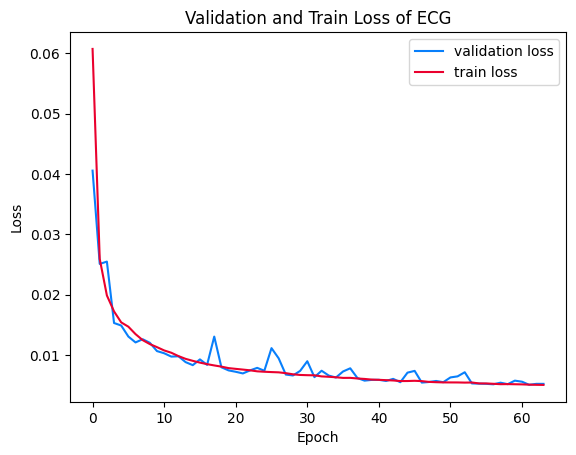

In [23]:
# VISUALIZATIONS FOR THE LEARNING BEHAVIOR

# Visualizes the the validation and train loss of the given loss.csv in one graph

filename = 'models/new/ecg/loss_ecg.csv'
# filename = 'models/new/wgn/loss_1_10.csv'
# filename = 'models/new/wgn/loss_2_10.csv'

directory = os.path.join('results', 'training')
if not os.path.exists(directory):
    os.makedirs(directory)

df = pd.read_csv(filename)

plt.plot(df['epoch'], df['val_loss'], color='#087ffb', label='validation loss')
plt.plot(df['epoch'], df['train_loss'], color='#ea002e', label='train loss')

plt.title('Validation and Train Loss of ECG')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig(os.path.join(directory, 'ecg.png'), format='png', bbox_inches='tight')
plt.show()

Sample index: 19151
RMSE 
Clean/Noise: 0.13304539024829865
Clean/Predicted: 0.10267644375562668


SNR 
Clean/Noise: -1.1193501204252243
Clean/Predicted: 5.42808473110199
Clean/BP: 2.5521375726058677


PCORR 
Clean/Noise: 0.584518220705078
Clean/Predicted: 0.7797071654808424
Clean/BP: 0.789761104738974




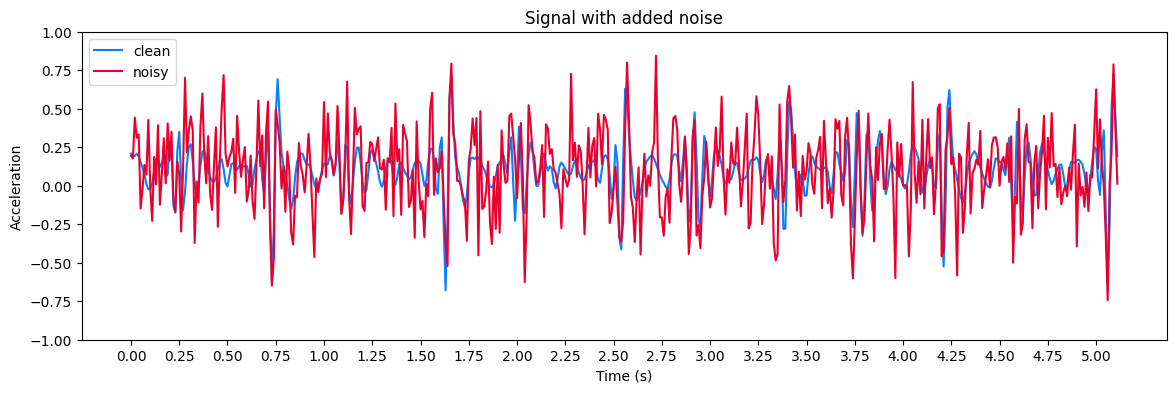

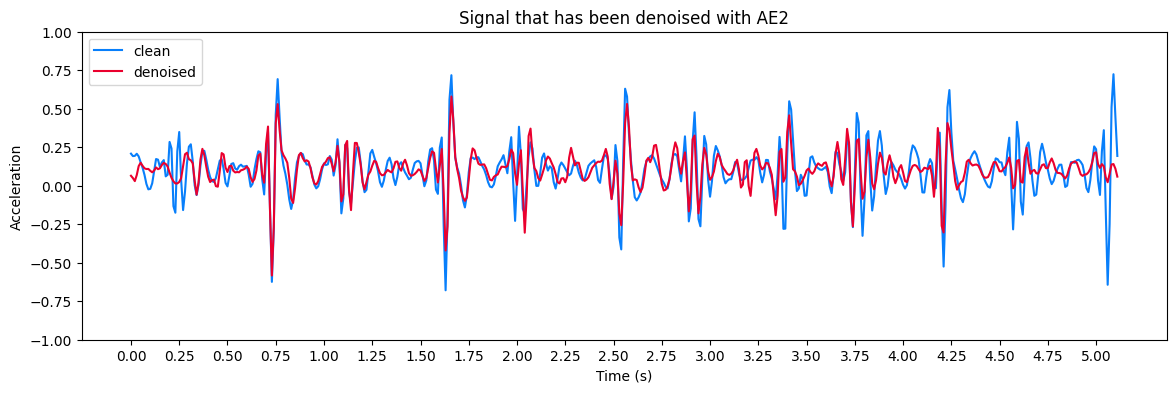

In [26]:
# VISUALIZATIONS FOR THE DENOISING PERFORMANCE AND THE NOISE MODEL

# Visualizes clean and noisy signal in one graph and the clean and denoised signal in another. 
# The signal will be selected randomly and the denoising method can be configured. What is more, the 
# implications of the used method on the transformation of scg to ecg can be visualized.

ecg = False

directory = os.path.join('results', 'denoising_viz')
if not os.path.exists(directory):
    os.makedirs(directory)

# model = DeNoise1(layer_size=256).to(device)
# model.load_state_dict(torch.load(os.path.join(model_directory, 'new/wgn/m2_128_20.pth'), map_location=torch.device(device)))

model = DeNoise2(layer_size=128).to(device)
model.load_state_dict(torch.load(os.path.join(model_directory, 'new/wgn/model_2_10.pth'), map_location=torch.device(device)))

model_ecg = DeNoise2(layer_size=256).to(device)
model_ecg.load_state_dict(torch.load(os.path.join(model_directory, 'new/ecg/model_ecg.pth'), map_location=torch.device(device)))

model.eval()
model_ecg.eval()

with torch.no_grad():
    
    i = random.choice(range(0, len(test_dataset)))
    # i = 13498
    print(f'Sample index: {i}')

    noise, clean = test_dataset[i]

    clean, noise = clean.reshape(-1, 1, window_size).to(device, dtype=torch.float), noise.reshape(-1, 1, window_size).to(device, dtype=torch.float)

    predicted = model(noise)
    # predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
    predicted_ecg = model_ecg(predicted)

    predicted = predicted.to('cpu').reshape(window_size).numpy()
    predicted_ecg = predicted_ecg.to('cpu').reshape(window_size).numpy()
    clean = clean.to('cpu').reshape(window_size).numpy()
    noise = noise.to('cpu').reshape(window_size).numpy()

    noise_snr = noise if ecg else denormalize(noise, test_dataset.dataset.min_val, test_dataset.dataset.max_val)
    predicted = predicted_ecg if ecg else predicted

    print(f'RMSE \nClean/Noise: {rmse(clean, noise)}\nClean/Predicted: {rmse(clean, predicted)}\n\n')
    print(f'SNR \nClean/Noise: {snr(clean, noise_snr)}\nClean/Predicted: {snr(clean, predicted)}\nClean/BP: {snr(clean, bandpass(predicted))}\n\n')
    print(f'PCORR \nClean/Noise: {pcorr(clean, noise)}\nClean/Predicted: {pcorr(clean, predicted)}\nClean/BP: {pcorr(clean, bandpass(predicted))}\n\n')
    
    
    time_from = 0
    time_to = 512

    # Clean/Noise Graph
    plt.figure(figsize=(14, 4))

    x = np.array(range(time_to)[time_from:time_to]) / sampling_rate
    plt.plot(x, clean[time_from:time_to], color='#087ffb', label='clean')
    plt.plot(x, noise_snr[time_from:time_to], color='#ea002e', label='noisy')
    plt.xticks(x[::25])
    
    plt.title('Signal with added noise')
    plt.xlabel('Time (s)')
    plt.ylabel(r'Acceleration')
    plt.ylim(bottom=-1, top=1)
    plt.legend()

    plt.savefig(os.path.join(directory, 'noise.png'), format='png', bbox_inches='tight')
    plt.show()


    # Clean/Denoised Graph
    plt.figure(figsize=(14, 4))

    x = np.array(range(time_to)[time_from:time_to]) / sampling_rate
    plt.plot(x, clean[time_from:time_to], color='#087ffb', label='clean')
    plt.plot(x, predicted[time_from:time_to], color='#ea002e', label='denoised')
    plt.xticks(x[::25])
    
    plt.title('Signal that has been denoised with AE2')
    plt.xlabel('Time (s)')
    plt.ylabel(r'Acceleration')
    plt.ylim(bottom=-1, top=1)
    plt.legend()

    plt.savefig(os.path.join(directory, 'denoising.png'), format='png', bbox_inches='tight')
    plt.show()

In [31]:
# COMPARISON OF DIFFERENT DENOISING METHODS

# Gives the percentage change of the specified denoising methods (column_1 and column_2)
# for specific scopes and a specific metric (mean or sd)

filename = 'results/2/wgn/results.json'

column_1 = 'AE1'
column_2 = 'AE2'
scopes = ['all']
metric = 'sd'

with open(filename) as json_file:
    results = json.load(json_file)

    for scope in scopes:
        print(f'Scope: {scope}')
        print('\033[1m{:^8} {:^8} {:^8} {:^8}\033[0m'.format('Evaluation', column_1, column_2, 'Percentual Change'))
        for evaluation in results[column_1][scope]:
            val = results[column_1][scope][evaluation][metric]
            val_cmp = results[column_2][scope][evaluation][metric]
            
            percentage_change = (val_cmp - val) / val * 100
            print(f'{evaluation:>8}: {val:>8.5f} {val_cmp:>8.5f} {percentage_change:>8.2f} %')

Scope: all
Evaluation   AE1      AE2    Percentual Change
  result:  0.12440  0.13036     4.79 %
 snr_imp:  8.07906  2.63749   -67.35 %
     mse:  0.01040  0.00826   -20.61 %
    rmse:  0.03296  0.03925    19.09 %
     mae:  0.03414  0.03110    -8.89 %
   xcorr:  0.00018  0.00014   -21.49 %
   pcorr:  0.11160  0.07852   -29.64 %
     prd: 350.61468 15.79214   -95.50 %
cpu_time:  0.00603  0.00598    -0.78 %


Sample index: 13498
Target SNR: -2.5
Acheived SNR: -2.397525287558062


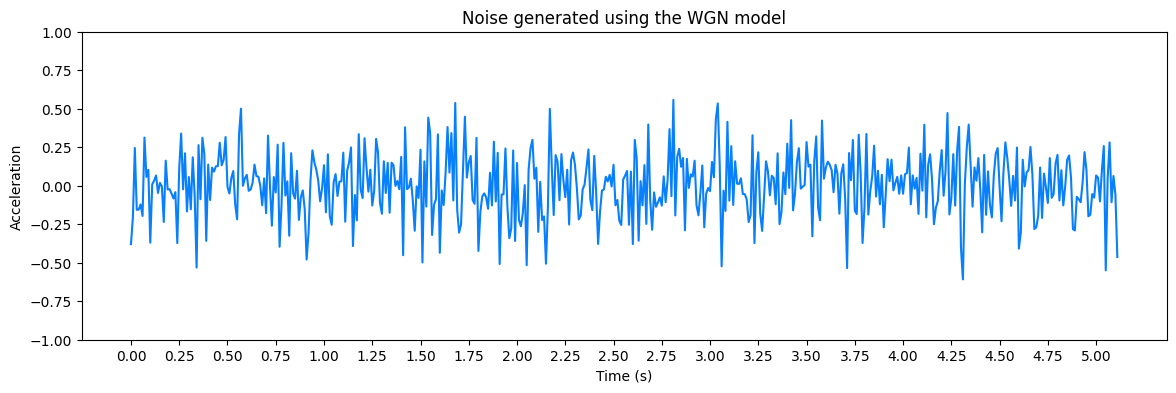

In [32]:
directory = os.path.join('results', 'noise_viz')
if not os.path.exists(directory):
    os.makedirs(directory)

i = random.choice(range(0, len(test_dataset)))
i = 13498
print(f'Sample index: {i}')

_, data = test_dataset[i]

data = data.numpy()

target_snr_db = -2.5
print(f'Target SNR: {target_snr_db}')

data_avg_watts = np.mean(data ** 2)
data_avg_db = 10 * np.log10(data_avg_watts)

noise_avg_db = data_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)

mean_noise = 0
noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data))

print(f'Acheived SNR: {snr(data, data + noise)}')


time_from = 0
time_to = 512 

plt.figure(figsize=(14, 4))

x = np.array(range(time_to)[time_from:time_to]) / sampling_rate
plt.plot(x, noise[time_from:time_to], color='#087ffb')
plt.xticks(x[::25])

plt.title('Noise generated using the WGN model')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration')
plt.ylim(bottom=-1, top=1)

plt.savefig(os.path.join(directory, 'noise.png'), format='png', bbox_inches='tight')
plt.show()